In [ ]:
!chmod +x kagglesetup.sh
!./kagglesetup.sh c tmdb-box-office-prediction

import os
!unzip train.csv.zip
!unzip test.csv.zip

 48% 5.00M/10.4M [00:00<00:00, 35.2MB/s]
100% 10.4M/10.4M [00:00<00:00, 41.2MB/s]
 85% 6.00M/7.05M [00:00<00:00, 61.5MB/s]
100% 7.05M/7.05M [00:00<00:00, 65.0MB/s]
  0% 0.00/60.1k [00:00<?, ?B/s]
100% 60.1k/60.1k [00:00<00:00, 63.0MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
df_train = pd.read_csv('train.csv')
df_train.loc[0, 'overview']

'When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.'

In [ ]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  doc = doc.strip()
  tokens = wpt.tokenize(doc)
  filtered_tokens = [token for token in tokens if token not in stop_words]
  doc = ' '.join(filtered_tokens)
  return doc

df_train['overview_norm'] = df_train['overview'].apply(lambda x: normalize_document(str(x)))
normalized_docs = np.array(df_train['overview_norm'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
normalized_docs.reshape(-1,1 )

array([['lou become father internet shot unknown assailant jacob nick fire time machine save friend'],
       ['mia thermopolis college graduate way genovia take duties princess best friend lilly also joins summer mia continues princess lessons riding horses sidesaddle archery royal complicated life turned upside learns take crown queen earlier expected'],
       ['direction ruthless instructor talented young drummer begins pursue perfection cost even humanity'],
       ...,
       ['samantha caine suburban homemaker ideal mom year old daughter caitlin lives honesdale pa job teaching school makes best rice krispie treats town receives bump head begins remember small parts previous life lethal topsecret agent'],
       ['reuben feffer guy whos spent entire life playing safe polly prince irresistible freespirit lives thrill moment two comically mismatched souls collide reubens world turned upside makes uproarious attempt change life middleoftheroad totallyoutthere'],
       ['young man s

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# get bag of words features in sparse format
cv = CountVectorizer(ngram_range=(1,2), min_df = 10, max_df = 0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(normalized_docs)
cv_array = cv_matrix.toarray()
vocab = cv.get_feature_names()
cv_matrix_df = pd.DataFrame(cv_array, columns = vocab)

In [ ]:
from sklearn.cluster import KMeans
NUM_CLUSTER = 10
km = KMeans(n_clusters = NUM_CLUSTER, max_iter = 500, n_init = 50, 
            random_state = 42).fit(cv_matrix)

In [ ]:
df_train['kmeans_cluster'] = km.labels_ 


In [ ]:
movie_clusters = (df_train[['title', 'kmeans_cluster', 'popularity']]
                  .sort_values(by = ['kmeans_cluster', 'popularity'],
                               ascending = False)
                  .groupby('kmeans_cluster').head(20))

movie_clusters = movie_clusters.copy(deep = True)
feature_names = cv.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]
for cluster_num in range(NUM_CLUSTER):
  key_features = [feature_names[idx] for idx in ordered_centroids[cluster_num,:topn_features]]
  movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
  print('CLUSTER # ' + str(cluster_num + 1))
  print('Key Features: ', key_features)
  print('Popular Movies: ', movies)
  print('-'*1000)

CLUSTER # 1
Key Features:  ['even', 'death', 'growing', 'old', 'paid', 'friends', 'gay', 'age', 'came', 'look', 'around', 'taking', 'alone', 'thinks', 'love']
Popular Movies:  ['Voracious']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
sample_plot = "Shaun is a salesman whose life has no direction. However, his uneventful life takes a sudden turn when he has to singlehandedly deal with an entire community of zombies."
norm_sample_plot = normalize_document(sample_plot)
transformed_plot = cv.transform([sample_plot])

In [ ]:
df_train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'overview_norm', 'kmeans_cluster'],
      dtype=object)

In [ ]:
predicted_cluster = km.predict(transformed_plot)
movies_in_same_cluster = df_train.loc[df_train['kmeans_cluster'] == predicted_cluster[0], ['title', 'genres']]
print(type(movies_in_same_cluster))
for idx, movie in movies_in_same_cluster.iterrows():
  print(movie['title'], movie['genres'])


<class 'pandas.core.frame.DataFrame'>
The Princess Diaries 2: Royal Engagement [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
Kahaani [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
American Beauty [{'id': 18, 'name': 'Drama'}]
Chalet Girl [{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]
Lost in Space [{'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}, {'id': 878, 'name': 'Science Fiction'}]
InSight [{'id': 53, 'name': 'Thriller'}, {'id': 9648, 'name': 'Mystery'}, {'id': 10769, 'name': 'Foreign'}]
What If [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]
The Last Witch Hunter [{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}]
Moscow, Belgium [{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]
Son in Law [{'id': 35, 'name': 'Comedy'}, {

### Finding the optimal number of clusters using elbow curve method.

100%|██████████| 10/10 [09:04<00:00, 54.43s/it]


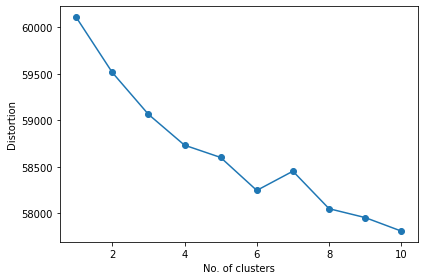

In [ ]:
from tqdm import tqdm
distortions = []
for i in tqdm(range(1, 11)):
  km_ = KMeans(n_clusters= i, max_iter = 400, n_init = 50)
  km_.fit(cv_matrix)
  distortions.append(km_.inertia_)


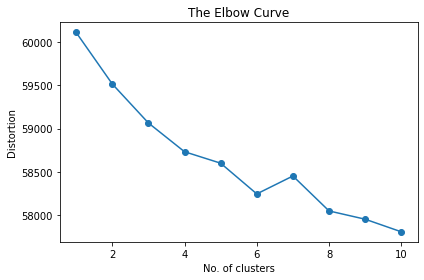

In [ ]:
plt.plot(range(1,11), distortions, marker = 'o')
plt.xlabel('No. of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Curve')
plt.tight_layout()
plt.show()